In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [7]:
!unzip -nq UCI-HAR.zip

In [8]:
# Obtain these by inspecting the files
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [9]:
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)

  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x

  # train labels
  Ytrain = pd.read_csv(
      f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1

  # test data
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x

  # test labels
  Ytest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1

  return Xtrain, Ytrain, Xtest, Ytest
Xtrain, Ytrain, Xtest, Ytest = load_data()

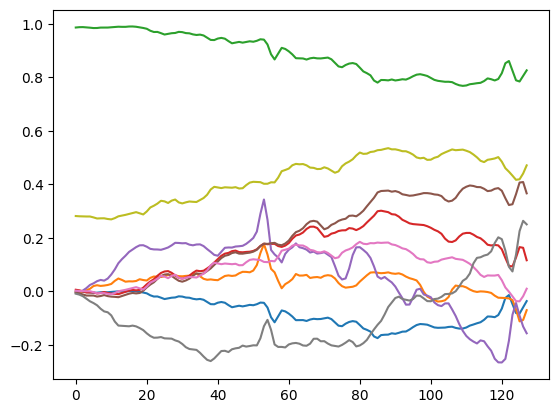

In [10]:
# plot all D=9 time series of length T=128
plt.plot(Xtrain[7000, :, :]);

In [11]:
# RNN
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
# x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [12]:
check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [13]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [14]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=10,
  callbacks=[check_point],
  validation_data=(Xtest, Ytest),
)

Epoch 1/10
230/230 [==============================] - 17s 62ms/step - loss: 1.0347 - accuracy: 0.7278 - val_loss: 0.8204 - val_accuracy: 0.7350
Epoch 2/10
  2/230 [..............................] - ETA: 14s - loss: 0.6823 - accuracy: 0.7656

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 14s 61ms/step - loss: 0.4847 - accuracy: 0.8807 - val_loss: 0.4527 - val_accuracy: 0.8700
Epoch 3/10
230/230 [==============================] - 14s 61ms/step - loss: 0.2894 - accuracy: 0.9161 - val_loss: 1.4769 - val_accuracy: 0.5724
Epoch 4/10
230/230 [==============================] - 13s 59ms/step - loss: 0.3585 - accuracy: 0.9038 - val_loss: 0.3230 - val_accuracy: 0.8965
Epoch 5/10
230/230 [==============================] - 14s 62ms/step - loss: 0.1956 - accuracy: 0.9362 - val_loss: 0.3153 - val_accuracy: 0.8839
Epoch 6/10
230/230 [==============================] - 14s 60ms/step - loss: 0.1698 - accuracy: 0.9416 - val_loss: 0.2619 - val_accuracy: 0.8877
Epoch 7/10
230/230 [==============================] - 14s 60ms/step - loss: 0.1418 - accuracy: 0.9480 - val_loss: 0.2917 - val_accuracy: 0.8853
Epoch 8/10
230/230 [==============================] - 13s 58ms/step - loss: 0.1382 - accuracy: 0.9512 - val_loss: 0.2557 - val_accuracy: 0.8965
Epo

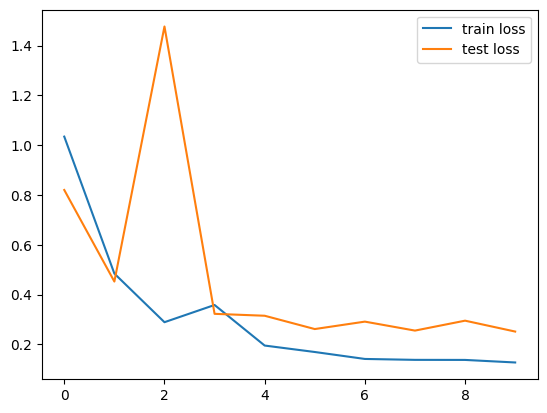

In [15]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

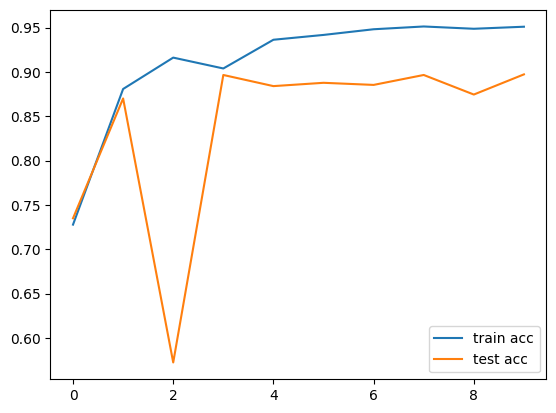

In [16]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [17]:
best_model = tf.keras.models.load_model('best_model.h5')
Ptest = best_model.predict(Xtest)
np.mean(np.argmax(Ptest, axis=1) == Ytest.flatten())

93/93 [==============================] - 2s 14ms/step


0.8971835765184933

In [18]:
from sklearn.preprocessing import StandardScaler

def load_features():
  # Returns:
  # X_train (Ntrain x D)
  # X_test (Ntest x D)

  # train data
  df = pd.read_csv(
        'UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True)

  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv(
        'UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True)

  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [19]:
feat_train, feat_test = load_features()
D_feat = feat_train.shape[1]

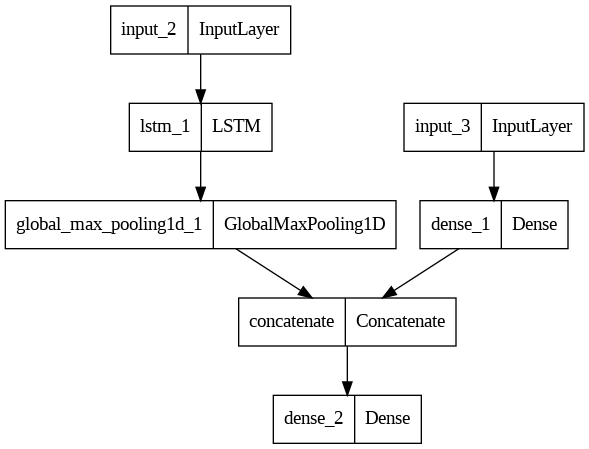

In [20]:
# RNN
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat,))
x2 = Dense(32, activation='relu')(i2)

x = Concatenate()([x, x2])
x = Dense(K)(x)
model = Model([i, i2], x)
tf.keras.utils.plot_model(model)

In [21]:
check_point = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [22]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [23]:
r = model.fit(
  [Xtrain, feat_train],
  Ytrain,
  epochs=15,
  callbacks=[check_point],
  validation_data=([Xtest, feat_test], Ytest),
)

Epoch 1/15
230/230 [==============================] - 18s 69ms/step - loss: 0.3311 - accuracy: 0.8870 - val_loss: 0.2096 - val_accuracy: 0.9237
Epoch 2/15
  3/230 [..............................] - ETA: 11s - loss: 0.1565 - accuracy: 0.9271

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 16s 70ms/step - loss: 0.1039 - accuracy: 0.9638 - val_loss: 0.2082 - val_accuracy: 0.9158
Epoch 3/15
230/230 [==============================] - 14s 62ms/step - loss: 0.0718 - accuracy: 0.9733 - val_loss: 0.1708 - val_accuracy: 0.9379
Epoch 4/15
230/230 [==============================] - 14s 62ms/step - loss: 0.0564 - accuracy: 0.9797 - val_loss: 0.1687 - val_accuracy: 0.9389
Epoch 5/15
230/230 [==============================] - 13s 58ms/step - loss: 0.0491 - accuracy: 0.9826 - val_loss: 0.1712 - val_accuracy: 0.9386
Epoch 6/15
230/230 [==============================] - 14s 59ms/step - loss: 0.0468 - accuracy: 0.9833 - val_loss: 0.1817 - val_accuracy: 0.9338
Epoch 7/15
230/230 [==============================] - 14s 60ms/step - loss: 0.0423 - accuracy: 0.9849 - val_loss: 0.2407 - val_accuracy: 0.9226
Epoch 8/15
230/230 [==============================] - 13s 58ms/step - loss: 0.0381 - accuracy: 0.9857 - val_loss: 0.2228 - val_accuracy: 0.9291
Epo

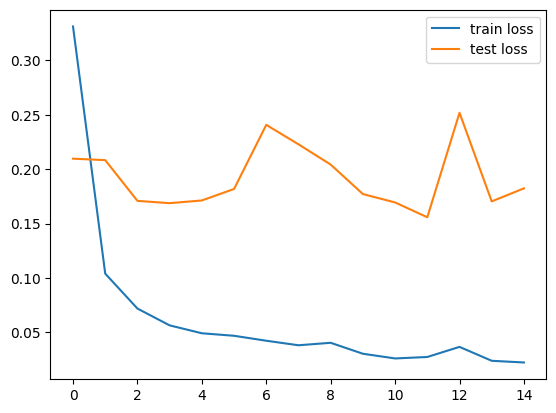

In [24]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

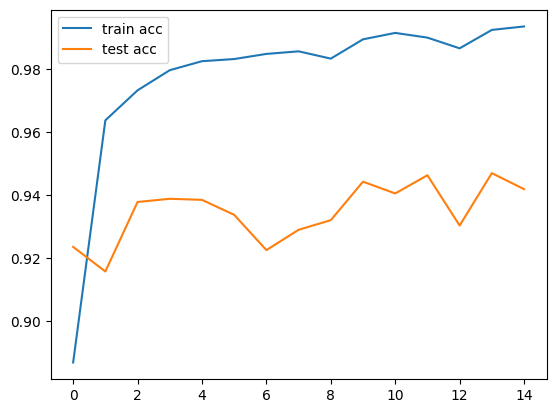

In [25]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [26]:
best_model = tf.keras.models.load_model('best_model.h5')
Ptest = best_model.predict([Xtest, feat_test])
np.mean(np.argmax(Ptest, axis=1) == Ytest.flatten())

93/93 [==============================] - 2s 16ms/step


0.9470648116728877